<a href="https://colab.research.google.com/github/nedokormysh/GB_PyTorch/blob/lesson3/GB_PyTorch_hw_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание.

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:

Создать Dataset для загрузки данных
Обернуть его в Dataloader
Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели
train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [ ]:
data = fetch_california_housing()

In [ ]:
df = pd.DataFrame(data.data, columns=data.feature_names)
# Добавим столбец "target" и заполним его данными.
df['target'] = data.target
# Посмотрим первые пять строк
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Нет пропусков и нет строковых признаков.

In [ ]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Диапазон значений разных признаков достаточно отличается, поэтмому проведём стандартизацию данных. 

In [ ]:
import math
import torch
import numpy as np

from sklearn.preprocessing import StandardScaler

class Clfrndataset(torch.utils.data.Dataset):
    def __init__(self, train=False):
      X, y = fetch_california_housing(return_X_y=True)
      scaler = StandardScaler()
      X = scaler.fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, 
                                                                test_size=0.25)

      # self.data = X
      # self.labels = y

      if train:
          self.data = X_train
          self.labels = y_train
      else:
          self.data = X_test
          self.labels = y_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index, :], self.labels[index]

In [ ]:
train_dataset = Clfrndataset(train=True)
test_dataset = Clfrndataset()


train_data_loader = torch.utils.data.DataLoader(train_dataset, 
                                                batch_size=32, 
                                                shuffle=True, 
                                                num_workers=1)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=8,
                                               num_workers=1)

In [ ]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu") -> None:
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "sigmoid":
            return torch.sigmoid(x)
        if self.activation == "elu":
            return F.elu(x)
        if self.activation == "tanh":
            return torch.tanh(x)
        raise RuntimeError

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = Perceptron(input_dim, hidden_dim, 'sigmoid')
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dp = nn.Dropout(0.25)
        self.fc2 = Perceptron(hidden_dim, 1, "relu")
        self.double() # для приведения типов
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.dp(x)
        x = self.bn(x)
        x = self.fc2(x)
        return x

In [ ]:
criterion = nn.MSELoss()

learning_rate = [0.01, 0.001, 0.0001, 0.00001]
epochs = [5, 10, 20]     

# Различные оптимизаторы с разными шагами обучения и количеством эпох

## SGD

In [ ]:
for num_epochs in epochs:
  for lr in learning_rate:
    print('\033[1m' + f'learning_rate = {lr}, numbers of epochs = {num_epochs}' + '\033[0m')

    net = FeedForward(8, 10)
    optimizer = optim.SGD(net.parameters(), lr=lr)

    for epoch in range(num_epochs):
      running_loss, running_items = 0.0, 0.0
      net.train()

      for i, data in enumerate(train_data_loader):
        inputs, labels = data[0], data[1]
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
                
        # выводим статистику о процессе обучения
        if i % 200 == 0:    # печатаем каждые 200 шагов
            net.eval()
            test_running_loss, test_running_total = 0.0, 0.0

            for j, data in enumerate(test_data_loader):
            
                test_outputs = net(data[0])
                test_running_total += len(data[1])
                test_loss = criterion(test_outputs.squeeze(), data[1]) 
                test_running_loss += test_loss.item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. '\
                  f'Test loss: {test_running_loss / test_running_total:.3f}')
            
            running_loss, running_items = 0.0, 0.0

            # net.train()
        
print('Training is finished!\n')

learning_rate = 0.01, numbers of epochs = 5
Epoch [1/5]. Step [1/484]. Loss: 0.184. Test loss: 0.707
Epoch [1/5]. Step [201/484]. Loss: 0.173. Test loss: 0.707
Epoch [1/5]. Step [401/484]. Loss: 0.178. Test loss: 0.707
Epoch [2/5]. Step [1/484]. Loss: 0.154. Test loss: 0.707
Epoch [2/5]. Step [201/484]. Loss: 0.173. Test loss: 0.707
Epoch [2/5]. Step [401/484]. Loss: 0.173. Test loss: 0.707
Epoch [3/5]. Step [1/484]. Loss: 0.151. Test loss: 0.707
Epoch [3/5]. Step [201/484]. Loss: 0.175. Test loss: 0.707
Epoch [3/5]. Step [401/484]. Loss: 0.175. Test loss: 0.707
Epoch [4/5]. Step [1/484]. Loss: 0.106. Test loss: 0.707
Epoch [4/5]. Step [201/484]. Loss: 0.173. Test loss: 0.707
Epoch [4/5]. Step [401/484]. Loss: 0.177. Test loss: 0.707
Epoch [5/5]. Step [1/484]. Loss: 0.193. Test loss: 0.707
Epoch [5/5]. Step [201/484]. Loss: 0.175. Test loss: 0.707
Epoch [5/5]. Step [401/484]. Loss: 0.163. Test loss: 0.173
learning_rate = 0.001, numbers of epochs = 5
Epoch [1/5]. Step [1/484]. Loss: 0.1

При малых шагах обучения модель обучается очень медленно. Также можем наблюдать переобучение модели на обучающей выборке.

## Adagrad

In [ ]:
for num_epochs in epochs:
  for lr in learning_rate:
    print('\033[1m' + f'learning_rate = {lr}, numbers of epochs = {num_epochs}' + '\033[0m')

    net = FeedForward(8, 10)
    optimizer = optim.Adagrad(net.parameters(), lr=lr)

    for epoch in range(num_epochs):
      running_loss, running_items = 0.0, 0.0
      net.train()

      for i, data in enumerate(train_data_loader):
        inputs, labels = data[0], data[1]
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
                
        # выводим статистику о процессе обучения
        if i % 200 == 0:    # печатаем каждые 200 шагов
            net.eval()
            test_running_loss, test_running_total = 0.0, 0.0

            for j, data in enumerate(test_data_loader):
            
                test_outputs = net(data[0])
                test_running_total += len(data[1])
                test_loss = criterion(test_outputs.squeeze(), data[1]) 
                test_running_loss += test_loss.item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. '\
                  f'Test loss: {test_running_loss / test_running_total:.3f}')
            
            running_loss, running_items = 0.0, 0.0

            # net.train()
        
print('Training is finished!\n')

learning_rate = 0.01, numbers of epochs = 5
Epoch [1/5]. Step [1/484]. Loss: 0.130. Test loss: 0.552
Epoch [1/5]. Step [201/484]. Loss: 0.053. Test loss: 0.133
Epoch [1/5]. Step [401/484]. Loss: 0.030. Test loss: 0.117
Epoch [2/5]. Step [1/484]. Loss: 0.095. Test loss: 0.110
Epoch [2/5]. Step [201/484]. Loss: 0.026. Test loss: 0.100
Epoch [2/5]. Step [401/484]. Loss: 0.023. Test loss: 0.093
Epoch [3/5]. Step [1/484]. Loss: 0.067. Test loss: 0.088
Epoch [3/5]. Step [201/484]. Loss: 0.020. Test loss: 0.083
Epoch [3/5]. Step [401/484]. Loss: 0.021. Test loss: 0.079
Epoch [4/5]. Step [1/484]. Loss: 0.071. Test loss: 0.077
Epoch [4/5]. Step [201/484]. Loss: 0.019. Test loss: 0.074
Epoch [4/5]. Step [401/484]. Loss: 0.017. Test loss: 0.072
Epoch [5/5]. Step [1/484]. Loss: 0.055. Test loss: 0.071
Epoch [5/5]. Step [201/484]. Loss: 0.016. Test loss: 0.069
Epoch [5/5]. Step [401/484]. Loss: 0.017. Test loss: 0.068
learning_rate = 0.001, numbers of epochs = 5
Epoch [1/5]. Step [1/484]. Loss: 0.1

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [16/20]. Step [1/484]. Loss: 0.101. Test loss: 0.058


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [16/20]. Step [201/484]. Loss: 0.014. Test loss: 0.058


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [16/20]. Step [401/484]. Loss: 0.014. Test loss: 0.058


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [17/20]. Step [1/484]. Loss: 0.112. Test loss: 0.058


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [17/20]. Step [201/484]. Loss: 0.014. Test loss: 0.058


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [17/20]. Step [401/484]. Loss: 0.014. Test loss: 0.058


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [18/20]. Step [1/484]. Loss: 0.126. Test loss: 0.058


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [18/20]. Step [201/484]. Loss: 0.014. Test loss: 0.058


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc66a3a1550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
self._shutdown_workers()            assert self._parent_pid == os.getpi

Epoch [18/20]. Step [401/484]. Loss: 0.014. Test loss: 0.057
Epoch [19/20]. Step [1/484]. Loss: 0.061. Test loss: 0.059
Epoch [19/20]. Step [201/484]. Loss: 0.014. Test loss: 0.058
Epoch [19/20]. Step [401/484]. Loss: 0.013. Test loss: 0.057
Epoch [20/20]. Step [1/484]. Loss: 0.098. Test loss: 0.058
Epoch [20/20]. Step [201/484]. Loss: 0.014. Test loss: 0.057
Epoch [20/20]. Step [401/484]. Loss: 0.013. Test loss: 0.057
learning_rate = 0.001, numbers of epochs = 20
Epoch [1/20]. Step [1/484]. Loss: 0.114. Test loss: 0.556
Epoch [1/20]. Step [201/484]. Loss: 0.121. Test loss: 0.460
Epoch [1/20]. Step [401/484]. Loss: 0.109. Test loss: 0.423
Epoch [2/20]. Step [1/484]. Loss: 0.107. Test loss: 0.416
Epoch [2/20]. Step [201/484]. Loss: 0.100. Test loss: 0.393
Epoch [2/20]. Step [401/484]. Loss: 0.094. Test loss: 0.374
Epoch [3/20]. Step [1/484]. Loss: 0.159. Test loss: 0.372
Epoch [3/20]. Step [201/484]. Loss: 0.091. Test loss: 0.357
Epoch [3/20]. Step [401/484]. Loss: 0.086. Test loss: 0.3

Adagrad работает более медленно, чем SGD

## RMSprop

In [ ]:
for num_epochs in epochs:
  for lr in learning_rate:
    print('\033[1m' + f'learning_rate = {lr}, numbers of epochs = {num_epochs}' + '\033[0m')

    net = FeedForward(8, 10)
    optimizer = optim.RMSprop(net.parameters(), lr=lr)

    for epoch in range(num_epochs):
      running_loss, running_items = 0.0, 0.0
      net.train()

      for i, data in enumerate(train_data_loader):
        inputs, labels = data[0], data[1]
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
                
        # выводим статистику о процессе обучения
        if i % 200 == 0:    # печатаем каждые 200 шагов
            net.eval()
            test_running_loss, test_running_total = 0.0, 0.0

            for j, data in enumerate(test_data_loader):
            
                test_outputs = net(data[0])
                test_running_total += len(data[1])
                test_loss = criterion(test_outputs.squeeze(), data[1]) 
                test_running_loss += test_loss.item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. '\
                  f'Test loss: {test_running_loss / test_running_total:.3f}')
            
            running_loss, running_items = 0.0, 0.0

            # net.train()
        
print('Training is finished!\n')

learning_rate = 0.01, numbers of epochs = 5
Epoch [1/5]. Step [1/484]. Loss: 0.160. Test loss: 0.215
Epoch [1/5]. Step [201/484]. Loss: 0.016. Test loss: 0.055
Epoch [1/5]. Step [401/484]. Loss: 0.013. Test loss: 0.054
Epoch [2/5]. Step [1/484]. Loss: 0.108. Test loss: 0.066
Epoch [2/5]. Step [201/484]. Loss: 0.013. Test loss: 0.054
Epoch [2/5]. Step [401/484]. Loss: 0.013. Test loss: 0.051
Epoch [3/5]. Step [1/484]. Loss: 0.141. Test loss: 0.060
Epoch [3/5]. Step [201/484]. Loss: 0.012. Test loss: 0.053
Epoch [3/5]. Step [401/484]. Loss: 0.012. Test loss: 0.050
Epoch [4/5]. Step [1/484]. Loss: 0.158. Test loss: 0.087
Epoch [4/5]. Step [201/484]. Loss: 0.012. Test loss: 0.050
Epoch [4/5]. Step [401/484]. Loss: 0.012. Test loss: 0.049
Epoch [5/5]. Step [1/484]. Loss: 0.132. Test loss: 0.077
Epoch [5/5]. Step [201/484]. Loss: 0.011. Test loss: 0.053
Epoch [5/5]. Step [401/484]. Loss: 0.012. Test loss: 0.048
learning_rate = 0.001, numbers of epochs = 5
Epoch [1/5]. Step [1/484]. Loss: 0.1

## Adam

In [ ]:
for num_epochs in epochs:
  for lr in learning_rate:
    print('\033[1m' + f'learning_rate = {lr}, numbers of epochs = {num_epochs}' + '\033[0m')

    net = FeedForward(8, 10)
    optimizer = optim.Adam(net.parameters(), lr=lr)

    for epoch in range(num_epochs):
      running_loss, running_items = 0.0, 0.0
      net.train()

      for i, data in enumerate(train_data_loader):
        inputs, labels = data[0], data[1]
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
                
        # выводим статистику о процессе обучения
        if i % 200 == 0:    # печатаем каждые 200 шагов
            net.eval()
            test_running_loss, test_running_total = 0.0, 0.0

            for j, data in enumerate(test_data_loader):
            
                test_outputs = net(data[0])
                test_running_total += len(data[1])
                test_loss = criterion(test_outputs.squeeze(), data[1]) 
                test_running_loss += test_loss.item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. '\
                  f'Test loss: {test_running_loss / test_running_total:.3f}')
            
            running_loss, running_items = 0.0, 0.0

            # net.train()
        
print('Training is finished!\n')

learning_rate = 0.01, numbers of epochs = 5
Epoch [1/5]. Step [1/484]. Loss: 0.129. Test loss: 0.707
Epoch [1/5]. Step [201/484]. Loss: 0.046. Test loss: 0.065
Epoch [1/5]. Step [401/484]. Loss: 0.015. Test loss: 0.055
Epoch [2/5]. Step [1/484]. Loss: 0.080. Test loss: 0.056
Epoch [2/5]. Step [201/484]. Loss: 0.013. Test loss: 0.052
Epoch [2/5]. Step [401/484]. Loss: 0.012. Test loss: 0.051
Epoch [3/5]. Step [1/484]. Loss: 0.154. Test loss: 0.052
Epoch [3/5]. Step [201/484]. Loss: 0.012. Test loss: 0.050
Epoch [3/5]. Step [401/484]. Loss: 0.012. Test loss: 0.050
Epoch [4/5]. Step [1/484]. Loss: 0.086. Test loss: 0.053
Epoch [4/5]. Step [201/484]. Loss: 0.011. Test loss: 0.049
Epoch [4/5]. Step [401/484]. Loss: 0.012. Test loss: 0.048
Epoch [5/5]. Step [1/484]. Loss: 0.095. Test loss: 0.050
Epoch [5/5]. Step [201/484]. Loss: 0.012. Test loss: 0.049
Epoch [5/5]. Step [401/484]. Loss: 0.012. Test loss: 0.048
learning_rate = 0.001, numbers of epochs = 5
Epoch [1/5]. Step [1/484]. Loss: 0.1

# Фиксированные параметры шага обучения. Различные оптимизаторы.

## SGD

In [ ]:
net = FeedForward(8, 10)
optimizer = optim.SGD(net.parameters(), lr=0.001)
num_epochs = 10
train_losses_SGD = []
test_losses_SGD = []


for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    net.train()

    for i, data in enumerate(train_data_loader):
        inputs, labels = data[0], data[1]
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
                
        # выводим статистику о процессе обучения
        if i % 200 == 0:    # печатаем каждые 200 шагов
            net.eval()
            test_running_loss, test_running_total = 0.0, 0.0

            for j, data in enumerate(test_data_loader):
            
                test_outputs = net(data[0])
                test_running_total += len(data[1])
                test_loss = criterion(test_outputs.squeeze(), data[1]) 
                test_running_loss += test_loss.item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. '\
                  f'Test loss: {test_running_loss / test_running_total:.3f}')
            
            train_losses_SGD.append(running_loss / running_items)
            test_losses_SGD.append(test_running_loss / test_running_total)
            running_loss, running_items = 0.0, 0.0
            
            # net.train()
        
print('Training is finished!\n')

Epoch [1/10]. Step [1/484]. Loss: 0.144. Test loss: 0.463
Epoch [1/10]. Step [201/484]. Loss: 0.060. Test loss: 0.163
Epoch [1/10]. Step [401/484]. Loss: 0.038. Test loss: 0.149
Epoch [2/10]. Step [1/484]. Loss: 0.123. Test loss: 0.146
Epoch [2/10]. Step [201/484]. Loss: 0.035. Test loss: 0.140
Epoch [2/10]. Step [401/484]. Loss: 0.033. Test loss: 0.135
Epoch [3/10]. Step [1/484]. Loss: 0.100. Test loss: 0.131
Epoch [3/10]. Step [201/484]. Loss: 0.032. Test loss: 0.124
Epoch [3/10]. Step [401/484]. Loss: 0.029. Test loss: 0.119
Epoch [4/10]. Step [1/484]. Loss: 0.090. Test loss: 0.115
Epoch [4/10]. Step [201/484]. Loss: 0.028. Test loss: 0.109
Epoch [4/10]. Step [401/484]. Loss: 0.026. Test loss: 0.104
Epoch [5/10]. Step [1/484]. Loss: 0.098. Test loss: 0.101
Epoch [5/10]. Step [201/484]. Loss: 0.024. Test loss: 0.096
Epoch [5/10]. Step [401/484]. Loss: 0.023. Test loss: 0.092
Epoch [6/10]. Step [1/484]. Loss: 0.065. Test loss: 0.089
Epoch [6/10]. Step [201/484]. Loss: 0.021. Test loss

## Adagrad

In [ ]:
net = FeedForward(8, 10)
optimizer = optim.Adagrad(net.parameters(), lr=0.001)
num_epochs = 10
train_losses_Adagrad = []
test_losses_Adagrad = []

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    net.train()

    for i, data in enumerate(train_data_loader):
        inputs, labels = data[0], data[1]
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
                
        # выводим статистику о процессе обучения
        if i % 200 == 0:    # печатаем каждые 200 шагов
            net.eval()
            test_running_loss, test_running_total = 0.0, 0.0

            for j, data in enumerate(test_data_loader):
            
                test_outputs = net(data[0])
                test_running_total += len(data[1])
                test_loss = criterion(test_outputs.squeeze(), data[1]) 
                test_running_loss += test_loss.item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. '\
                  f'Test loss: {test_running_loss / test_running_total:.3f}')
            
            
            train_losses_Adagrad.append(running_loss / running_items)
            test_losses_Adagrad.append(test_running_loss / test_running_total)

            running_loss, running_items = 0.0, 0.0
        
print('Training is finished!\n')

Epoch [1/10]. Step [1/484]. Loss: 0.220. Test loss: 0.692
Epoch [1/10]. Step [201/484]. Loss: 0.155. Test loss: 0.586
Epoch [1/10]. Step [401/484]. Loss: 0.141. Test loss: 0.537
Epoch [2/10]. Step [1/484]. Loss: 0.136. Test loss: 0.529
Epoch [2/10]. Step [201/484]. Loss: 0.127. Test loss: 0.498
Epoch [2/10]. Step [401/484]. Loss: 0.121. Test loss: 0.472
Epoch [3/10]. Step [1/484]. Loss: 0.157. Test loss: 0.475
Epoch [3/10]. Step [201/484]. Loss: 0.114. Test loss: 0.455
Epoch [3/10]. Step [401/484]. Loss: 0.108. Test loss: 0.437
Epoch [4/10]. Step [1/484]. Loss: 0.118. Test loss: 0.442
Epoch [4/10]. Step [201/484]. Loss: 0.106. Test loss: 0.426
Epoch [4/10]. Step [401/484]. Loss: 0.104. Test loss: 0.412
Epoch [5/10]. Step [1/484]. Loss: 0.136. Test loss: 0.415
Epoch [5/10]. Step [201/484]. Loss: 0.101. Test loss: 0.402
Epoch [5/10]. Step [401/484]. Loss: 0.099. Test loss: 0.389
Epoch [6/10]. Step [1/484]. Loss: 0.124. Test loss: 0.393
Epoch [6/10]. Step [201/484]. Loss: 0.097. Test loss

## RMSprop

In [ ]:
net = FeedForward(8, 10)
optimizer = optim.RMSprop(net.parameters(), lr=0.001)
num_epochs = 10
train_losses_RMSprop = []
test_losses_RMSprop = []

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    net.train()

    for i, data in enumerate(train_data_loader):
        inputs, labels = data[0], data[1]
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
                
        # выводим статистику о процессе обучения
        if i % 200 == 0:    # печатаем каждые 200 шагов
            net.eval()
            test_running_loss, test_running_total = 0.0, 0.0

            for j, data in enumerate(test_data_loader):
            
                test_outputs = net(data[0])
                test_running_total += len(data[1])
                test_loss = criterion(test_outputs.squeeze(), data[1]) 
                test_running_loss += test_loss.item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. '\
                  f'Test loss: {test_running_loss / test_running_total:.3f}')
            
            train_losses_RMSprop.append(running_loss / running_items)
            test_losses_RMSprop.append(test_running_loss / test_running_total)

            running_loss, running_items = 0.0, 0.0
        
print('Training is finished!\n')

Epoch [1/10]. Step [1/484]. Loss: 0.131. Test loss: 0.515
Epoch [1/10]. Step [201/484]. Loss: 0.043. Test loss: 0.120
Epoch [1/10]. Step [401/484]. Loss: 0.025. Test loss: 0.092
Epoch [2/10]. Step [1/484]. Loss: 0.078. Test loss: 0.081
Epoch [2/10]. Step [201/484]. Loss: 0.019. Test loss: 0.071
Epoch [2/10]. Step [401/484]. Loss: 0.017. Test loss: 0.066
Epoch [3/10]. Step [1/484]. Loss: 0.109. Test loss: 0.065
Epoch [3/10]. Step [201/484]. Loss: 0.015. Test loss: 0.061
Epoch [3/10]. Step [401/484]. Loss: 0.015. Test loss: 0.060
Epoch [4/10]. Step [1/484]. Loss: 0.121. Test loss: 0.060
Epoch [4/10]. Step [201/484]. Loss: 0.014. Test loss: 0.058
Epoch [4/10]. Step [401/484]. Loss: 0.014. Test loss: 0.057
Epoch [5/10]. Step [1/484]. Loss: 0.079. Test loss: 0.059
Epoch [5/10]. Step [201/484]. Loss: 0.014. Test loss: 0.057
Epoch [5/10]. Step [401/484]. Loss: 0.014. Test loss: 0.057
Epoch [6/10]. Step [1/484]. Loss: 0.072. Test loss: 0.057
Epoch [6/10]. Step [201/484]. Loss: 0.013. Test loss

## Adam

In [ ]:
net = FeedForward(8, 10)
optimizer = optim.Adam(net.parameters(), lr=0.001)
num_epochs = 10
train_losses_Adam = []
test_losses_Adam = []

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    net.train()

    for i, data in enumerate(train_data_loader):
        inputs, labels = data[0], data[1]
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
                
        # выводим статистику о процессе обучения
        if i % 200 == 0:    # печатаем каждые 200 шагов
            net.eval()
            test_running_loss, test_running_total = 0.0, 0.0

            for j, data in enumerate(test_data_loader):
            
                test_outputs = net(data[0])
                test_running_total += len(data[1])
                test_loss = criterion(test_outputs.squeeze(), data[1]) 
                test_running_loss += test_loss.item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. '\
                  f'Test loss: {test_running_loss / test_running_total:.3f}')
            
            train_losses_Adam.append(running_loss / running_items)
            test_losses_Adam.append(test_running_loss / test_running_total)

            running_loss, running_items = 0.0, 0.0
        
print('Training is finished!\n')

Epoch [1/10]. Step [1/484]. Loss: 0.139. Test loss: 0.620
Epoch [1/10]. Step [201/484]. Loss: 0.078. Test loss: 0.136
Epoch [1/10]. Step [401/484]. Loss: 0.027. Test loss: 0.100
Epoch [2/10]. Step [1/484]. Loss: 0.088. Test loss: 0.091
Epoch [2/10]. Step [201/484]. Loss: 0.021. Test loss: 0.080
Epoch [2/10]. Step [401/484]. Loss: 0.018. Test loss: 0.073
Epoch [3/10]. Step [1/484]. Loss: 0.056. Test loss: 0.070
Epoch [3/10]. Step [201/484]. Loss: 0.016. Test loss: 0.067
Epoch [3/10]. Step [401/484]. Loss: 0.016. Test loss: 0.064
Epoch [4/10]. Step [1/484]. Loss: 0.098. Test loss: 0.064
Epoch [4/10]. Step [201/484]. Loss: 0.015. Test loss: 0.061
Epoch [4/10]. Step [401/484]. Loss: 0.014. Test loss: 0.059
Epoch [5/10]. Step [1/484]. Loss: 0.086. Test loss: 0.059
Epoch [5/10]. Step [201/484]. Loss: 0.013. Test loss: 0.058
Epoch [5/10]. Step [401/484]. Loss: 0.015. Test loss: 0.057
Epoch [6/10]. Step [1/484]. Loss: 0.081. Test loss: 0.058
Epoch [6/10]. Step [201/484]. Loss: 0.013. Test loss

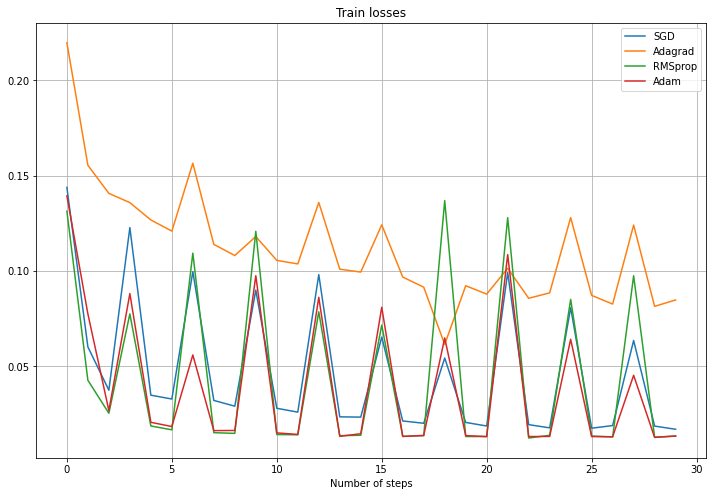

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Train losses')
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adagrad, label='Adagrad')
plt.plot(train_losses_RMSprop, label='RMSprop')
plt.plot(train_losses_Adam, label='Adam')
plt.xlabel('Number of steps')
plt.grid()
plt.legend();

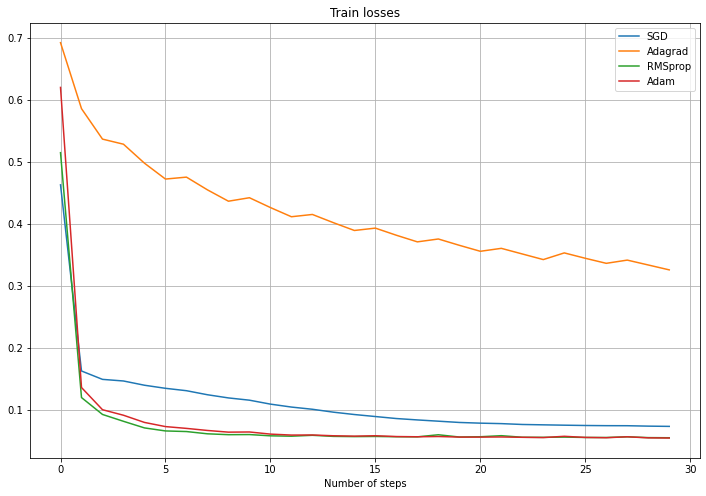

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Train losses')
plt.plot(test_losses_SGD, label='SGD')
plt.plot(test_losses_Adagrad, label='Adagrad')
plt.plot(test_losses_RMSprop, label='RMSprop')
plt.plot(test_losses_Adam, label='Adam')
plt.xlabel('Number of steps')
plt.grid()
plt.legend();

Rmsprop и Adam показали очень схожие результаты. Медленне всего обучался Adagrad. SGD с данными параметрами возможно вообще не сошёлся.